     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ConfigSpace: filename=ConfigSpace-1.2.0-py3-none-any.whl size=115855 sha256=7a98b1c96a3d40699d9a18a39bd87c2fd5352359b8f665682f7848a7ad423530
  Stored in directory: /root/.cache/pip/wheels/5f/1f/4b/450c9c9d1ede888e354984d9eba7e60f13878fa079d502d52e
Successfully built ConfigSpace
Mounted at /content/drive/
4
External surrogate Model Evaluation: - MSE: 0.0007, R2: 0.9858
Spearman Correlation: 0.9964
0.1543853999999999
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9998
Spearman Correlation: 0.9998
0.17640000000000086
External surrogate Model Evaluation: - MSE: 0.0001, R2: 0.9909
Spearman Correlation: 0.9974
0.024638709677419594
External surrogate Model Evaluation: - MSE: 0.0001, R2: 0.9955
Spearman Correlation: 0.9926
0.5209159999999954
[{'succe

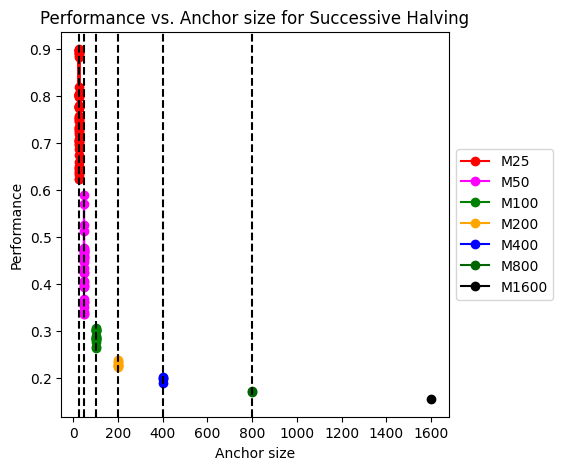

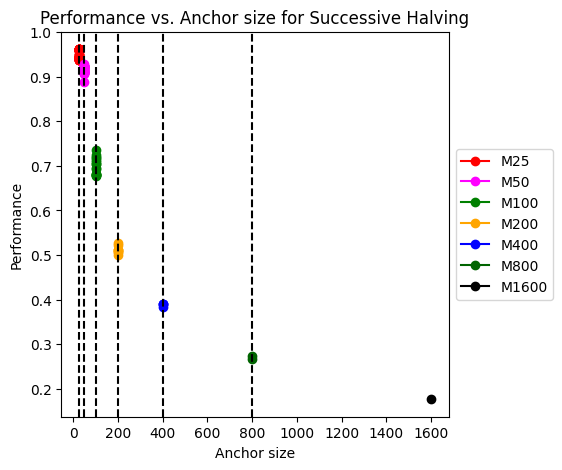

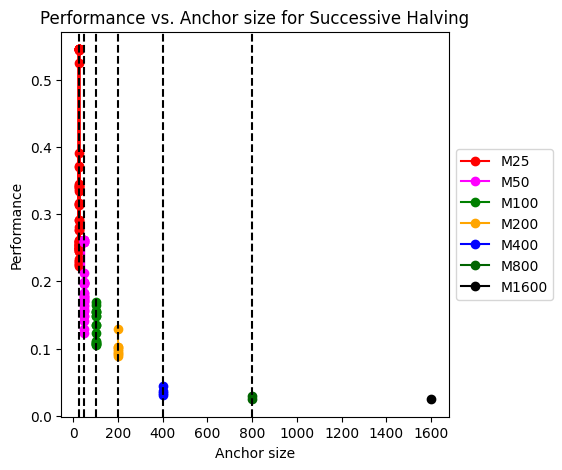

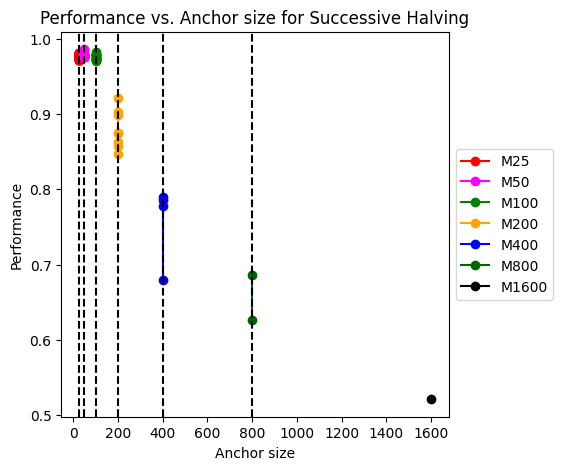

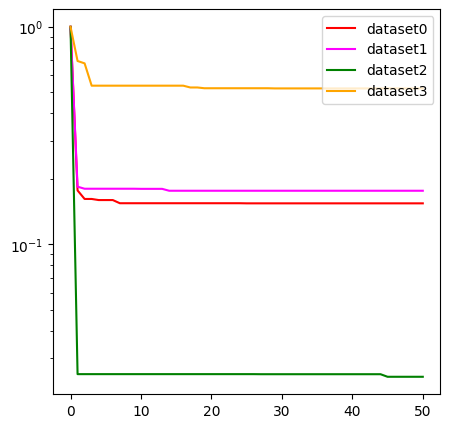

In [1]:
!pip install ConfigSpace
from google.colab import drive
import argparse
from scipy.stats import spearmanr
import typing
import ConfigSpace
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import sklearn.impute
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class RandomSearch(object):

    def __init__(self, config_space: ConfigSpace.ConfigurationSpace):
        self.config_space = config_space

    def initialize(self, capital_phi: typing.List[typing.Tuple[typing.Dict, float]]) -> None:
        pass

    def select_configuration(self) -> ConfigSpace.Configuration:
        return self.config_space.sample_configuration(1)

    def update_runs(self, run: typing.Tuple[typing.Dict, float]):
        pass

class SurrogateModel:

    def __init__(self, config_space):
        self.config_space = config_space
        self.df = None
        self.model = None

    def fit(self, df):
        """
        Receives a data frame, in which each column (except for the last two) represents a hyperparameter, the
        penultimate column represents the anchor size, and the final column represents the performance.

        :param df: the dataframe with performances
        :return: Does not return anything, but stores the trained model in self.model
        """
        self.df = df
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        # fit the external surrogate model using OneHotEncoder
        categorical_features = x.select_dtypes(include=['object']).columns.tolist()
        numerical_features = x.select_dtypes(include=['number']).columns.tolist()
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', sklearn.impute.SimpleImputer(strategy='mean'), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ])

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=1000, random_state=40))
        ])
        model.fit(x_train, y_train)
        self.model = model

        pred = model.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        corr, _ = spearmanr(y_test, pred)
        print(f"External surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")
        print(f"Spearman Correlation: {corr:.4f}")


    def predict(self, theta_new):
        """
        Predicts the performance of a given configuration theta_new

        :param theta_new: a dict, where each key represents the hyperparameter (or anchor)
        :return: float, the predicted performance of theta new (which can be considered the ground truth)
        """
        if self.model == None:
            raise ValueError("Train the model first.")
        # fill the keys without full dictionary with default values of the config space
        else:
            for key in dict(self.config_space).keys():
                if key not in theta_new.keys():
                    theta_new[key] = dict(self.config_space)[key].default_value
            list_theta = [theta_new]
            x_test = pd.DataFrame(list_theta)
            x_test = x_test[self.df.keys()[:-1]]
        # predict the performance as ground truth

            y_test = self.model.predict(x_test)
            return y_test[0]

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config_space_file', type=str, default='/content/drive/MyDrive/lcdb_config_space_knn.json')
    parser.add_argument('--configurations_performance_file', type=str, default='lcdb_configs.csv')
    parser.add_argument('--configurations_performance_file_1', type=str, default='config_performances_dataset-6.csv')
    parser.add_argument('--configurations_performance_file_2', type=str, default='config_performances_dataset-11.csv')
    parser.add_argument('--configurations_performance_file_3', type=str, default='config_performances_dataset-1457.csv')

    # max_anchor_size: connected to the configurations_performance_file. The max value upon which anchors are sampled
    parser.add_argument('--max_anchor_size', type=int, default=1600)
    parser.add_argument('--num_iterations', type=int, default=50)

    return parser.parse_known_args()[0]

def run(args):
    config_space = ConfigSpace.ConfigurationSpace.from_json(args.config_space_file)
    df_list = []
    df_1 = pd.read_csv(args.configurations_performance_file)
    df_2 = pd.read_csv(args.configurations_performance_file_1)
    df_3 = pd.read_csv(args.configurations_performance_file_2)
    df_4 = pd.read_csv(args.configurations_performance_file_3)
    df_list.append(df_1)
    df_list.append(df_2)
    df_list.append(df_3)
    df_list.append(df_4)
    colors = ['red', 'magenta', 'green', 'orange']

    resultss = []
    for df in df_list:
      halving_factor = 2
      surrogate_model = SurrogateModel(config_space)
      surrogate_model.fit(df)

      results = {
          'successive halving': [1.0]
      }
      best_performance = []
      best = np.inf
      for idx in range(args.num_iterations):
          total_anchor = [0]
          total_performance = {}

          # anchor size to be 10% of data
          current_anchor = 25
          configs = [dict(config_space.sample_configuration()) for _ in range(64)]
          while(current_anchor<=args.max_anchor_size):
              total_anchor.append(current_anchor)
              performances = []
              m = len(configs)

              for config in configs:
                  for hp in list(config_space.values()):
                      if hp.name not in config.keys():
                          config[hp.name] = hp.default_value
                  config['anchor_size'] = current_anchor

                  performance = surrogate_model.predict(config)
                  performances.append(performance)

              total_performance['M'+str(current_anchor)] = performances
              performances = np.array(performances)
              performances_sorted = np.argsort(performances)
              num = int(m/halving_factor)

              configs = [configs[index] for index in performances_sorted[:num]]
              current_anchor *= halving_factor

          p = total_performance.get(list(total_performance.keys())[-1])[0]
          if p < best:
              best = p
              best_performance.append(total_performance)
          results['successive halving'].append(min(results['successive halving'][-1], best))

      resultss.append(results)
      colors = ['red', 'magenta', 'green', 'orange', 'blue', 'darkgreen', 'black', 'gray']
      fig = plt.figure(figsize=(5, 5))
      ax1 = fig.add_subplot(1, 1, 1)
      for i, (label, performance) in enumerate(best_performance[-1].items()):
          valid_budgets = [total_anchor[i+1]] * len(performance)
          ax1.plot(valid_budgets, performance, label=label, color=colors[i % len(colors)], marker='o')

      for budget_cut in total_anchor[1:-1]:
          ax1.axvline(x=budget_cut, color='black', linestyle='--')

      ax1.set_xlabel('Anchor size')
      ax1.set_ylabel('Performance')
      ax1.set_title('Performance vs. Anchor size for Successive Halving')

      ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      print(min(results['successive halving']))

    fig = plt.figure(figsize=(5, 5))
    i = 0
    for results in resultss:
        plt.plot(range(len(results['successive halving'])), results['successive halving'], color=colors[i], label='dataset'+str(i))
        plt.yscale('log')
        plt.legend(loc="upper right")
        i += 1
    plt.show()

if __name__ == '__main__':
    run(parse_args())